In [1]:
import pandas as pd
import utility as utils
import importlib
import numpy as np
import librosa

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split

importlib.reload(utils)

train_dataset = '/Users/borosabel/Doc/Uni/4/ASP_2024/data/train'
test_dataset = '/Users/borosabel/Doc/Uni/4/ASP_2024/data/test'

In [2]:
df = utils.get_audio_and_onsets_in_dataframe(train_dataset)

<b>Building up the labels</b>

In [3]:
import argparse
import json
import os
import numpy as np
import mir_eval

def evaluate_loop(submission, target):
    f, _, _ = mir_eval.onset.f_measure(
        np.array(target),
        np.array(submission),
        window=0.05  # 50 [ms]
    )
    return f

In [4]:
# def onsets_to_labels(onsets, total_duration=None):
#     frame_length = 0.1
#     hop_length = 0.005
#     if total_duration is None:
#         total_duration = max(onsets) + frame_length
#     num_frames = int(np.ceil(total_duration / hop_length))
#     frame_times = np.arange(num_frames) * hop_length
#     labels = np.zeros(num_frames, dtype=int)
#     for onset in onsets:
#         # Find the closest frame index for each onset
#         frame_index = int(np.floor(onset / hop_length))
#         labels[frame_index] = 1
#     return labels, frame_times

def labels_to_onsets(labels, frame_times):
    hop_length = 0.005
    onset_indices = np.where(labels == 1)[0]
    onset_times = frame_times[onset_indices] + hop_length / 2 
    return list(onset_times)

def onsets_to_labels(onsets, total_duration=None, num_frames=None):
    frame_length = 0.1
    hop_length = 0.005
    if num_frames is None:
        if total_duration is None:
            total_duration = max(onsets) + frame_length
        num_frames = int(np.ceil(total_duration / hop_length))
    frame_times = np.arange(num_frames) * hop_length
    labels = np.zeros(num_frames, dtype=int)
    for onset in onsets:
        frame_index = int(np.floor(onset / hop_length))
        labels[frame_index] = 1
    return labels, frame_times

def compute_frame_level_features(audio_path, sr=utils.SAMPLING_RATE, frame_length=0.1, hop_length=0.005):
    y, sr = librosa.load(audio_path, sr=sr)  # Load the audio file

    frame_length_samples = int(frame_length * sr)
    hop_length_samples = int(hop_length * sr)

    # Compute Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_length_samples, hop_length=hop_length_samples)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Directly derive number of frames from the spectrogram's shape
    num_frames = S_dB.shape[1]

    # Compute MFCC and its deltas
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=frame_length_samples, hop_length=hop_length_samples)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    # Flatten these matrices into vectors for each frame
    S_dB_flattened = S_dB.T  # Already the correct shape
    mfccs_flattened = mfccs.T
    delta_mfccs_flattened = delta_mfccs.T
    delta2_mfccs_flattened = delta2_mfccs.T

    # Concatenate all features for each frame
    features_per_frame = np.hstack([S_dB_flattened, mfccs_flattened, delta_mfccs_flattened, delta2_mfccs_flattened])

    return features_per_frame, num_frames


# def compute_features(audio_path, frame_length=0.1, hop_length=0.005):
#     # Load audio
#     y, sr = librosa.load(audio_path, sr=utils.SAMPLING_RATE)  # Use audio's original sampling rate
# 
#     # Convert frame and hop length from seconds to samples
#     frame_length_samples = int(frame_length * sr)
#     hop_length_samples = int(hop_length * sr)
# 
#     # Feature extraction
#     rms = librosa.feature.rms(y=y, frame_length=frame_length_samples, hop_length=hop_length_samples).flatten()
#     zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length_samples, hop_length=hop_length_samples).flatten()
#     spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length_samples, hop_length=hop_length_samples).flatten()
#     spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=frame_length_samples, hop_length=hop_length_samples).flatten()
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=frame_length_samples, hop_length=hop_length_samples)
# 
#     # Flatten MFCCs (from 2D array to 2D where rows are frames)
#     mfcc = mfcc.T
# 
#     # Concatenate all features
#     features = np.hstack([rms[:, np.newaxis], zcr[:, np.newaxis], spec_centroid[:, np.newaxis], spec_rolloff[:, np.newaxis], mfcc])
# 
#     return features

In [5]:
def extract_data(X, y):
    all_features = []
    all_labels = []

    for audio_path, onsets in zip(X, y):
        features, num_frames = compute_frame_level_features(audio_path)
        labels, frame_times = onsets_to_labels(onsets, num_frames=num_frames)

        # Ensure the length of features and labels are the same
        min_length = min(len(labels), len(features))
        features = features[:min_length]
        labels = labels[:min_length]

        all_features.append(features)
        all_labels.append(labels)

    # Concatenate all features and labels from list of arrays to a single array
    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)

    return all_features, all_labels

In [6]:
features = df['File Path']
labels = df['Onsets']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
features_train, labels_train = extract_data(X_train, y_train)
features_test, labels_test = extract_data(X_test, y_test)
features_val, labels_val = extract_data(X_val, y_val)

In [21]:
# make same ammount of 1s and 0s in the dataframe
indices_1 = np.where(labels_train == 1)[0]
indices_0 = np.where(labels_train == 0)[0]

n_class_1 = len(indices_1)
np.random.seed(42)  # Seed for reproducibility
sampled_indices_0 = np.random.choice(indices_0, n_class_1, replace=False)
balanced_indices = np.concatenate([indices_1, sampled_indices_0])
np.random.shuffle(balanced_indices)
balanced_features_train = features_train[balanced_indices]
balanced_labels_train = labels_train[balanced_indices]

In [24]:
# make same ammount of 1s and 0s in the dataframe
indices_1 = np.where(labels_val == 1)[0]
indices_0 = np.where(labels_val == 0)[0]

n_class_1 = len(indices_1)
np.random.seed(42)  # Seed for reproducibility
sampled_indices_0 = np.random.choice(indices_0, n_class_1, replace=False)
balanced_indices = np.concatenate([indices_1, sampled_indices_0])
np.random.shuffle(balanced_indices)
balanced_features_val = features_val[balanced_indices]
balanced_labels_val = labels_val[balanced_indices]

In [25]:
scaler = StandardScaler()
features_train_norm = scaler.fit_transform(balanced_features_train)
features_test_norm = scaler.transform(features_test)
features_val_norm = scaler.transform(balanced_features_val)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2,
                           scoring='f1', n_jobs=-1)

grid_search.fit(features_train_norm, balanced_labels_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [76]:
# df[['frame_times', 'onset_labels']] = df.apply(utils.process_audio, axis=1)

In [113]:
import librosa
import numpy as np
import pandas as pd

import librosa
import numpy as np

def extract_features_per_frame(y, sr, n_fft, hop_length):
    # Extract base MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Setup to only calculate deltas if enough frames are available
    min_delta_width = 9  # Minimum number of frames needed for the specified delta width
    num_frames = mfcc.shape[1]

    if num_frames >= min_delta_width:
        # Calculate first-order and second-order deltas
        mfcc_delta = librosa.feature.delta(mfcc, width=9)
        mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2, width=9)
        mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)
        delta_features = np.hstack((mfcc_delta_mean, mfcc_delta2_mean))
    else:
        # If not enough frames, use zeros as placeholder
        delta_features = np.zeros(mfcc_mean.shape[0] * 2)  # 2 for delta and delta2

    # Other features
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    chroma_mean = np.mean(chroma, axis=1)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_centroid_mean = np.mean(spectral_centroid)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)

    # Concatenate all features into a single feature vector
    features = np.hstack((
        mfcc_mean,
        delta_features,
        spectral_contrast_mean,
        chroma_mean,
        [spectral_centroid_mean, zero_crossing_rate_mean]
    ))

    return features

def process_audio_and_extract_features(row, sampling_rate, mode='train'):
    if mode == 'train':
        audio_path = row['File Path']
    else:
        audio_path = row
    y, sr = librosa.load(audio_path, sr=sampling_rate)

    frame_length = int(0.1 * sr)  # 100 ms frame length
    hop_length = frame_length  # Hop length equals frame length for non-overlapping frames

    # Calculate features for each frame
    features = []
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    for frame in frames.T:  # Transpose frames to iterate over them
        feature = extract_features_per_frame(frame, sr, frame_length, hop_length)
        features.append(feature)

    if mode == 'train':
        # Generate labels as done previously
        onsets = row['Onsets']
        frame_times = librosa.frames_to_time(range(frames.shape[1]), sr=sr, hop_length=hop_length)
        onset_labels = np.zeros(len(frame_times), dtype=int)
        for onset in onsets:
            frame_idx = np.argmin(np.abs(frame_times - onset))
            onset_labels[frame_idx] = 1

        return pd.Series({
            'features': np.array(features),
            'onset_labels': onset_labels
        })
    else:
        # For testing, return features only
        return pd.Series({
            'features': np.array(features)
        })

In [89]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas(desc="Processing Audio Files")
sampling_rate = utils.SAMPLING_RATE
df[['features', 'onset_labels']] = df.progress_apply(process_audio_and_extract_features, args=(sampling_rate,), axis=1)

Processing Audio Files:   1%|          | 2/277 [00:01<03:35,  1.28it/s]/Users/borosabel/lib/python3.9/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing Audio Files: 100%|██████████| 277/277 [14:32<00:00,  3.15s/it]  


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Example of reshaping and normalizing data
X = np.vstack(df['features'].values)  # Stack features
y = np.hstack(df['onset_labels'].values)  # Stack labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training+validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    return model

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X_train_val, y_train_val):
    # Split data
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

    # Define the model architecture
    model = create_model(X_train.shape[1])

    # Fit data to model
    history = model.fit(X_train, y_train,
                        batch_size=10,
                        epochs=100,
                        verbose=0,
                        validation_data=(X_val, y_val))

    # Generate generalization metrics
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# # Prepare the data
# X = np.array(X)  # Ensure X is a NumPy array
# y = np.array(y)  # Ensure y is a NumPy array
# 
# # Stratified K-Fold
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# f1_scores = []
# reports = []
# 
# for train, test in kfold.split(X, y):
#     model = create_model(X.shape[1])  # Create a new model instance for each fold
# 
#     # Train the model
#     model.fit(X[train], y[train], epochs=10, batch_size=10, verbose=0)
# 
#     # Predict on the validation fold
#     y_pred = (model.predict(X[test]) > 0.5).astype(int)
# 
#     # Calculate F1 score and store detailed classification report
#     f1_scores.append(f1_score(y[test], y_pred))
#     report = classification_report(y[test], y_pred, target_names=['No Onset', 'Onset'], output_dict=True)
#     reports.append(report)
# 
# # Print average F1 score across all folds
# print("F1 Score: %.2f%% (+/- %.2f%%)" % (np.mean(f1_scores) * 100, np.std(f1_scores) * 100))
# 
# # Optionally, print average precision and recall for each class
# average_reports = {}
# for label in ['No Onset', 'Onset']:
#     precision_list = [rep[label]['precision'] for rep in reports if label in rep]
#     recall_list = [rep[label]['recall'] for rep in reports if label in rep]
#     average_reports[label] = {
#         'precision': np.mean(precision_list),
#         'recall': np.mean(recall_list)
#     }
# 
# print("Average Precision and Recall by Class:")
# for label, metrics in average_reports.items():
#     print(f"{label} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}")

/Users/borosabel/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score for fold 1: loss of 0.5577056407928467; compile_metrics of 69.38376426696777%
Score for fold 2: loss of 0.5610558986663818; compile_metrics of 68.90089511871338%
Score for fold 3: loss of 0.5630598664283752; compile_metrics of 68.84341239929199%
Score for fold 4: loss of 0.5576456785202026; compile_metrics of 69.32628154754639%
Score for fold 5: loss of 0.5574686527252197; compile_metrics of 69.57571506500244%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5577056407928467 - Accuracy: 69.38376426696777%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5610558986663818 - Accuracy: 68.90089511871338%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5630598664283752 - Accuracy: 68.84341239929199%
------------------------------------------------------------------------

In [94]:
# Evaluate the model on the test set
test_metrics = model.evaluate(X_test, y_test)

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print classification report for test set
report = classification_report(y_test, y_pred, target_names=['No Onset', 'Onset'])
print(report)

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - Precision: 0.6777 - Recall: 0.4176 - accuracy: 0.6950 - loss: 0.5612
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
              precision    recall  f1-score   support

    No Onset       0.70      0.87      0.78      6593
       Onset       0.68      0.43      0.53      4280

    accuracy                           0.70     10873
   macro avg       0.69      0.65      0.65     10873
weighted avg       0.69      0.70      0.68     10873


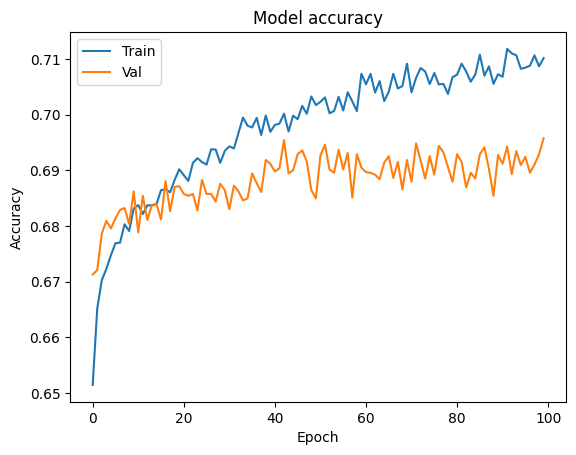

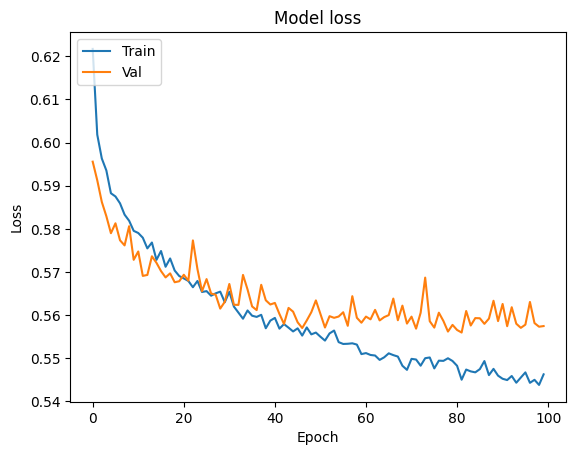

In [95]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [9]:
df['Labels'] = df.apply(lambda row: utils.get_onsets_frames(row['File Path'], row['Onsets']), axis=1)

In [10]:
X = df.drop(['Onsets', 'Labels'], axis=1)  # Feature matrix
y = df['Labels']

In [11]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler

def extract_features_and_labels(audio_path, frame_labels):
    # Load audio and compute STFT magnitude
    y, sr = librosa.load(audio_path, sr=utils.SAMPLING_RATE)
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=utils.HOP_LENGTH))

    # Compute basic spectral features
    spectral_centroids = librosa.feature.spectral_centroid(S=S, sr=sr, hop_length=utils.HOP_LENGTH)
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, hop_length=utils.HOP_LENGTH)

    # Compute MFCCs and their deltas
    mfcc = librosa.feature.mfcc(S=S, sr=sr, n_mfcc=13, hop_length=utils.HOP_LENGTH)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Compute wider range deltas for spectral centroids and rolloff
    delta_wide_centroids = librosa.feature.delta(spectral_centroids, width=3)
    delta_wide_rolloff = librosa.feature.delta(spectral_rolloff, width=3)
    delta2_wide_centroids = librosa.feature.delta(spectral_centroids, order=2, width=3)
    delta2_wide_rolloff = librosa.feature.delta(spectral_rolloff, order=2, width=3)
    delta_wide2_rolloff = librosa.feature.delta(spectral_rolloff, width=5)
    delta2_wide2_centroids = librosa.feature.delta(spectral_centroids, order=2, width=5)
    delta2_wide2_rolloff = librosa.feature.delta(spectral_rolloff, order=2, width=5)
    delta_wide3_rolloff = librosa.feature.delta(spectral_rolloff, width=7)
    delta2_wide3_centroids = librosa.feature.delta(spectral_centroids, order=2, width=7)
    delta2_wide3_rolloff = librosa.feature.delta(spectral_rolloff, order=2, width=7)

    # Compile all features for each frame into one large feature matrix
    features = np.hstack([
        spectral_centroids.T, spectral_rolloff.T,
        delta_wide_centroids.T, delta_wide_rolloff.T,
        delta2_wide_centroids.T, delta2_wide_rolloff.T,
        delta_wide2_rolloff.T, delta2_wide2_centroids.T,
        delta2_wide2_rolloff.T, delta_wide3_rolloff.T,
        delta2_wide3_centroids.T, delta2_wide3_rolloff.T,
        mfcc.T, delta_mfcc.T, delta2_mfcc.T  # Include MFCCs and their deltas
    ])

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features)

    # Ensure features and labels are the same length to avoid any misalignment
    min_length = min(features_normalized.shape[0], len(frame_labels))
    features_normalized = features_normalized[:min_length]
    frame_labels = frame_labels[:min_length]

    return features_normalized, frame_labels

In [12]:
audio_paths = df['File Path']
labels = df['Labels']

In [13]:
all_features = []
all_labels = []

for path, label in zip(audio_paths, labels):
    feats, lbls = extract_features_and_labels(path, label)
    if feats.shape[0] == lbls.shape[0]:
        all_features.append(feats)
        all_labels.append(lbls)

# Flatten lists if needed (depends on your model input requirements)
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

In [14]:
all_features

array([[ 0.4080049 ,  0.06692919, -1.01535217, ..., -1.87347574,
        -1.81410376, -1.72534261],
       [ 0.15047801, -0.05303954, -1.01535217, ..., -1.87347574,
        -1.81410376, -1.72534261],
       [-0.25141901, -0.46093322, -1.26085114, ..., -1.87347574,
        -1.81410376, -1.72534261],
       ...,
       [ 5.9890607 ,  4.49469669,  7.56072462, ...,  0.4714278 ,
         0.4817774 ,  0.461646  ],
       [ 6.00269146,  4.50751122, -0.34934379, ...,  0.4714278 ,
         0.4817774 ,  0.461646  ],
       [ 5.78865091,  4.46906763, -0.34934379, ...,  0.4714278 ,
         0.4817774 ,  0.461646  ]])

In [24]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import tensorflow as tf

groups = np.array([i for i, labels in enumerate(y) for _ in range(len(labels))])

print("Features shape:", all_features.shape)
print("Labels shape:", all_labels.shape)
print("Groups shape:", groups.shape)

group_kfold = GroupKFold(n_splits=5)

for train_idx, test_idx in group_kfold.split(all_features, all_labels, groups):
    X_train, X_test = all_features[train_idx], all_features[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]

    X_train_reshaped = X_train.reshape(X_train.shape[0], -1, 1)
    y_train_reshaped = y_train.reshape(y_train.shape[0], -1, 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1, 1)

    # Define the RNN model
    model = Sequential([
        SimpleRNN(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score()])

    model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, verbose=1)

    # Evaluate the model
    predictions = model.predict(X_test_reshaped)
    binary_predictions = (predictions > 0.5).astype(int)  # apply threshold
    
    # Reshape predictions and labels
    binary_predictions = binary_predictions.squeeze()  # Remove singleton dimensions
    y_test = y_test.squeeze()  # Remove singleton dimensions
    
    print(classification_report(y_test, binary_predictions))

Features shape: (210336, 51)
Labels shape: (210336,)
Groups shape: (210336,)
Epoch 1/10


/Users/borosabel/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: FBetaScore expects 2D inputs with shape (batch_size, output_dim). Received input shapes: y_pred.shape=(None, 1) and y_true.shape=(None, 1, 1).

In [407]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold

param_test = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

groups = np.array([i for i, labels in enumerate(y) for _ in range(len(labels))])

print("Features shape:", all_features.shape)
print("Labels shape:", all_labels.shape)
print("Groups shape:", groups.shape)

group_kfold = GroupKFold(n_splits=5)
classifier = XGBClassifier(n_estimators=300, scale_pos_weight=10)

gsearch = GridSearchCV(estimator = XGBClassifier(n_estimators=300, scale_pos_weight=10),
                       param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=group_kfold.split(all_features, all_labels, groups))
gsearch.fit(all_features, all_labels)
print(gsearch.best_params_, gsearch.best_score_)

Features shape: (210336, 51)
Labels shape: (210336,)
Groups shape: (210336,)


/Users/borosabel/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'colsample_bytree': 1.0, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0} 0.884038221526926


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

groups = np.array([i for i, labels in enumerate(y) for _ in range(len(labels))])

print("Features shape:", all_features.shape)
print("Labels shape:", all_labels.shape)
print("Groups shape:", groups.shape)

group_kfold = GroupKFold(n_splits=5)
model1 = XGBClassifier(n_estimators=300, scale_pos_weight=10, gamma=0, max_depth=3, min_child_weight=1, colsample_bytree=1, subsample=1)
model2 = LogisticRegression()
model3 = SVC(probability=True)

# Create the ensemble model
ensemble = VotingClassifier(estimators=[
    ('xgb', model1), ('lr', model2), ('svc', model3)],
    voting='soft')

for train_idx, test_idx in group_kfold.split(all_features, all_labels, groups):
    X_train, X_test = all_features[train_idx], all_features[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]

    # Train the model
    ensemble.fit(X_train, y_train)

    # Evaluate the model
    predictions = ensemble.predict(X_test)
    print(classification_report(y_test, predictions))

Features shape: (210336, 51)
Labels shape: (210336,)
Groups shape: (210336,)


/Users/borosabel/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     39101
           1       0.64      0.24      0.34      2908

    accuracy                           0.94     42009
   macro avg       0.79      0.61      0.66     42009
weighted avg       0.92      0.94      0.92     42009


/Users/borosabel/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [328]:
test_x, test_y = df.iloc[0]['File Path'], df.iloc[0]['Labels']

In [329]:
all_features = []
all_labels = []

feats, lbls = extract_features_and_labels(test_x, test_y)
if feats.shape[0] == lbls.shape[0]:
    all_features.append(feats)
    all_labels.append(lbls)

# Flatten lists if needed (depends on your model input requirements)
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

In [336]:
predictions = []
predicted_onsets = classifier.predict(all_features)

In [342]:
onset_indices = list(np.where(predicted_onsets == 1)[0])

In [344]:
predicted_onset_times = librosa.frames_to_time(onset_indices, sr=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH)

In [334]:
onset_times = df.iloc[0]['Onsets']

In [345]:
y, sr = librosa.load(test_x, sr=utils.SAMPLING_RATE)

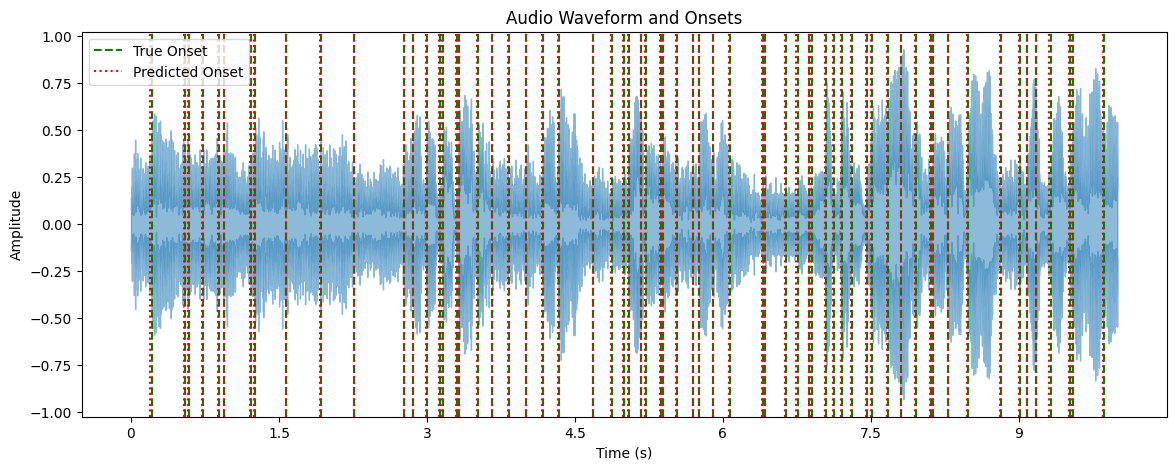

In [348]:
import matplotlib.pyplot as plt

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=utils.SAMPLING_RATE, alpha=0.5)
plt.title('Audio Waveform and Onsets')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Add lines for true onsets
for onset in onset_times:
    plt.axvline(x=onset, color='g', linestyle='--', label='True Onset' if onset == onset_times[0] else "")

# Add lines for predicted onsets
for pred in predicted_onset_times:
    plt.axvline(x=pred, color='r', linestyle=':', label='Predicted Onset' if pred == predicted_onset_times[0] else "")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [121]:
wav_files_paths, _, _, _ = utils.load_dataset_paths(test_dataset)

In [122]:
onsets = {}

In [123]:
for path in wav_files_paths:
    file_name = path.split('/')[-1].replace('.wav', '')
    features = process_audio_and_extract_features(path, utils.SAMPLING_RATE, mode='Test')
    features = np.vstack(features) 
    predicted_onsets_frames = model.predict(features)
    onset_indices = list(np.where(predicted_onsets_frames == 1)[0])
    predicted_onset_times = librosa.frames_to_time(onset_indices, sr=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH)
    onsets[file_name] = {'onsets': list(predicted_onset_times)}

/Users/borosabel/lib/python3.9/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━

In [124]:
import json

json_filename = 'onsets_data_3.json'
with open(json_filename, 'w') as f:
    json.dump(onsets, f, indent=4)